In [1]:
import os
import random
import warnings

import matplotlib
import matplotlib.pyplot as plt
import simplstyles
import numpy as np
import pandas as pd
from himalaya.backend import set_backend
from scipy.interpolate import griddata, CloughTocher2DInterpolator

from residual import residual_method
from simulation import generate_dataset
from variance_partitioning import variance_partitioning

matplotlib.interactive(True)

In [2]:
plt.style.use('nord-light-talk')

In [3]:
def save_scores(scalars_list, d_list, n_targets, n_samples, noise_target, cv, alphas):
    path = get_path(alphas, cv, n_targets)
    for scalars in scalars_list:
        print(scalars)
        csv_path = os.path.join(path, f"scores_{scalars}.csv")
        scores = pd.DataFrame()
        if os.path.exists(csv_path):
            print("skipping, already exists")
            continue
        Xs, Y = generate_dataset(d_list, scalars, n_targets, n_samples, noise_target)
        print("data generated")
        x1_score, x2_score, joint_score, x1_and_x2_score, vp_x1_unique_score, vp_x2_unique_score = variance_partitioning(
            Xs, Y, n_samples_train, alphas, cv)
        print("variance partitioning done")

        scores["x1_score"] = x1_score
        scores["x2_score"] = x2_score
        scores["vp_joint_score"] = joint_score
        scores["vp_shared_score"] = x1_and_x2_score
        scores["vp_x1_unique_score"] = vp_x1_unique_score
        scores["vp_x2_unique_score"] = vp_x2_unique_score
        del x1_score, x2_score, joint_score, x1_and_x2_score, vp_x1_unique_score, vp_x2_unique_score
        print(scores.head())

        x2_to_x1_score, x1_to_x2_score, rm_x1_unique_score, rm_x2_unique_score = residual_method(
            Xs, Y, n_samples_train, alphas, cv)
        print("residual method done")
        scores["rm_x2_to_x1_score"] = np.concatenate(
            [x2_to_x1_score, np.full(len(rm_x1_unique_score) - len(x2_to_x1_score), np.nan)])
        scores["rm_x1_to_x2_score"] = np.concatenate(
            [x1_to_x2_score, np.full(len(rm_x1_unique_score) - len(x1_to_x2_score), np.nan)])
        scores["rm_x1_unique_score"] = rm_x1_unique_score
        scores["rm_x2_unique_score"] = rm_x2_unique_score
        del x2_to_x1_score, x1_to_x2_score, rm_x1_unique_score, rm_x2_unique_score
        del Xs, Y
        scores.to_csv(csv_path, index=False)

In [4]:
def get_path(alphas, cv, n_targets):
    path = os.path.join("results", f"targets={n_targets}", f"cv={cv}",
                        f"alphas={alphas.min()},{alphas.max()},{len(alphas)}", "varying scalars")
    os.makedirs(path, exist_ok=True)
    return path

In [5]:
def plot_simplex(metric_values, interp_type='linear', fig=None, ax=None, min_total=None, max_total=None,
                 cmap=plt.get_cmap().reversed(), plot_coords=False):
    """Plots a simplex heatmap based on provided metric values.

    Args:
        metric_values: A list or numpy array of metric values corresponding to each point in the simplex.
                      The length must match the number of generated scalar points.
        interp_type: Type of interpolation to use. Can be 'linear', 'clough_tocher', or 'cubic'. Defaults to 'linear'.
    """
    if len(metric_values) != len(scalars_list):
        raise ValueError("Length of metric_values must match the number of scalar points.")

    if interp_type not in ['linear', 'clough_tocher', 'cubic']:
        raise ValueError("Invalid interpolation type. Choose 'linear', 'clough_tocher', or 'cubic'.")

    # Convert to barycentric coordinates
    barycentric_coords = scalars_list

    # Check if ax is provided or create a simplex plot
    if ax is None:
        fig, ax = plt.subplots()

    # Define simplex corners
    corners = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3) / 2]])

    # Corner labels
    corner_labels = ['(1, 0, 0)', '(0, 1, 0)', '(0, 0, 1)']

    # Transform barycentric coordinates to Cartesian
    cartesian_coords = np.dot(barycentric_coords, corners)

    # Create grid for interpolation
    resolution = 1000  # Adjust resolution as needed
    x = np.linspace(0, 1, resolution)
    y = np.linspace(0, np.sqrt(3) / 2, resolution)
    xx, yy = np.meshgrid(x, y)
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Filter grid points that are outside the triangle
    triangle = matplotlib.patches.Polygon(corners, closed=True)
    mask = triangle.contains_points(grid_points)
    grid_points_filtered = grid_points[mask]

    # Interpolate values on the grid
    if interp_type == 'linear':
        interp_values = griddata(cartesian_coords, metric_values, grid_points_filtered, method='linear')
    elif interp_type == 'clough_tocher':
        interp = CloughTocher2DInterpolator(cartesian_coords, metric_values)
        interp_values = interp(grid_points_filtered)
    elif interp_type == 'cubic':
        interp_values = griddata(cartesian_coords, metric_values, grid_points_filtered, method='cubic')

    # Reshape interpolated values
    zz = np.full_like(xx.ravel(), np.nan)
    zz[mask] = interp_values
    zz = zz.reshape(xx.shape)

    # if total value ranges are given use those, otherwise not
    if min_total is not None and max_total is not None:
        vmin = min_total
        vmax = max_total
    else:
        vmin = np.nanmin(zz)
        vmax = np.nanmax(zz)

    # Plot the colored triangle
    im = ax.imshow(zz, extent=[0, 1, 0, np.sqrt(3) / 2], origin='lower', cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)

    # Add a colorbar
    if fig is not None:
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label('Metric Value')

    # Draw the triangle boundaries (optional, if you want to highlight them)
    ax.plot([corners[0, 0], corners[1, 0]], [corners[0, 1], corners[1, 1]], 'k-')
    ax.plot([corners[1, 0], corners[2, 0]], [corners[1, 1], corners[2, 1]], 'k-')
    ax.plot([corners[2, 0], corners[0, 0]], [corners[2, 1], corners[0, 1]], 'k-')

    # plot points where values are plotted

    if plot_coords:
        for i, (x, y) in enumerate(cartesian_coords):
            scalar_label = f"({scalars_list[i][0]:.2f}, {scalars_list[i][1]:.2f}, {scalars_list[i][2]:.2f})"
            ax.text(x, y + 0.03, scalar_label, ha='center', va='center', fontsize=5, color='black')
            ax.scatter(x, y, c=metric_values[i], cmap=cmap, vmin=vmin, vmax=vmax, marker='^')

    # Add corner labels
    halignments = ['left', 'right', 'center']
    valignments = ['top', 'top', 'bottom']
    for i, label in enumerate(corner_labels):
        ax.text(corners[i, 0], corners[i, 1], corner_labels[i], ha=halignments[i], va=valignments[i])

    # Remove x and y axes
    ax.set_xticks([])
    ax.set_yticks([])

    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)

    # remove background
    ax.set_facecolor('white')

    return fig, ax, im

In [6]:
def generate_barycentric_coordinates(x):
    """
    Generates barycentric coordinates for a simplex with x subdivisions.

    Args:
        x: The number of subdivisions.

    Returns:
        A NumPy array of barycentric coordinates.
    """

    coordinates = []
    for i in range(x + 1):
        for j in range(x - i + 1):
            k = x - i - j
            coordinates.append([i / x, j / x, k / x])

    return np.array(coordinates)

# Generate scalar points

In [7]:
SUBDIVISIONS = 8

In [8]:
scalars_list = generate_barycentric_coordinates(SUBDIVISIONS)
print(len(scalars_list))
scalars_list

45


array([[0.   , 0.   , 1.   ],
       [0.   , 0.125, 0.875],
       [0.   , 0.25 , 0.75 ],
       [0.   , 0.375, 0.625],
       [0.   , 0.5  , 0.5  ],
       [0.   , 0.625, 0.375],
       [0.   , 0.75 , 0.25 ],
       [0.   , 0.875, 0.125],
       [0.   , 1.   , 0.   ],
       [0.125, 0.   , 0.875],
       [0.125, 0.125, 0.75 ],
       [0.125, 0.25 , 0.625],
       [0.125, 0.375, 0.5  ],
       [0.125, 0.5  , 0.375],
       [0.125, 0.625, 0.25 ],
       [0.125, 0.75 , 0.125],
       [0.125, 0.875, 0.   ],
       [0.25 , 0.   , 0.75 ],
       [0.25 , 0.125, 0.625],
       [0.25 , 0.25 , 0.5  ],
       [0.25 , 0.375, 0.375],
       [0.25 , 0.5  , 0.25 ],
       [0.25 , 0.625, 0.125],
       [0.25 , 0.75 , 0.   ],
       [0.375, 0.   , 0.625],
       [0.375, 0.125, 0.5  ],
       [0.375, 0.25 , 0.375],
       [0.375, 0.375, 0.25 ],
       [0.375, 0.5  , 0.125],
       [0.375, 0.625, 0.   ],
       [0.5  , 0.   , 0.5  ],
       [0.5  , 0.125, 0.375],
       [0.5  , 0.25 , 0.25 ],
       [0.

# Generate data

In [9]:
backend = set_backend("cupy", on_error="warn")
warnings.filterwarnings("ignore")
random.seed(42)

/home/leo/PycharmProjects/compare_variance_residual/venv/lib/python3.12/site-packages/himalaya/backend/_utils.py:55: UserWarning: Setting backend to cupy failed: Cupy not installed..Falling back to numpy backend.
  warnings.warn(f"Setting backend to {backend} failed: {str(error)}."


In [10]:
d_list = [100, 100, 100]
n_targets = 10000
n_samples_train = 10000
n_samples_test = 100
n_samples = n_samples_train + n_samples_test
noise_target = 0.1

cv = 10
alphas = np.logspace(-5, 5, 10)
path = get_path(alphas, cv, n_targets)

In [11]:
save_scores(scalars_list, d_list, n_targets, n_samples, noise_target, cv, alphas)

[0. 0. 1.]
skipping, already exists
[0.    0.125 0.875]
skipping, already exists
[0.   0.25 0.75]
skipping, already exists
[0.    0.375 0.625]
skipping, already exists
[0.  0.5 0.5]
skipping, already exists
[0.    0.625 0.375]
skipping, already exists
[0.   0.75 0.25]
skipping, already exists
[0.    0.875 0.125]
skipping, already exists
[0. 1. 0.]
skipping, already exists
[0.125 0.    0.875]
skipping, already exists
[0.125 0.125 0.75 ]
skipping, already exists
[0.125 0.25  0.625]
skipping, already exists
[0.125 0.375 0.5  ]
skipping, already exists
[0.125 0.5   0.375]
skipping, already exists
[0.125 0.625 0.25 ]
skipping, already exists
[0.125 0.75  0.125]
skipping, already exists
[0.125 0.875 0.   ]
skipping, already exists
[0.25 0.   0.75]
skipping, already exists
[0.25  0.125 0.625]
skipping, already exists
[0.25 0.25 0.5 ]
skipping, already exists
[0.25  0.375 0.375]
skipping, already exists
[0.25 0.5  0.25]
skipping, already exists
[0.25  0.625 0.125]
skipping, already exists
[0.2

plot points on triangle simplex

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7cbed2731df0>)

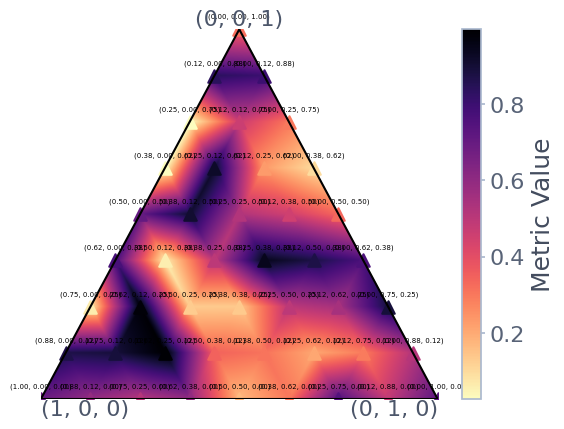

In [12]:
plot_simplex(np.random.rand(len(scalars_list)), plot_coords=True)

# plot mean error

In [24]:
vp_x1_mean_error_predicted = []
vp_x2_mean_error_predicted = []
rm_x1_mean_error_predicted = []
rm_x2_mean_error_predicted = []

vp_x1_std_errors = []
vp_x2_std_errors = []
rm_x1_std_errors = []
rm_x2_std_errors = []

for scalars in scalars_list:
    scores = pd.read_csv(
        os.path.join(get_path(alphas, cv, n_targets), f"scores_{scalars}.csv"))
    print("read scores for ", scalars)

    # calculate error
    vp_x1_error = scores["vp_x1_unique_score"] - scalars[1]
    vp_x2_error = scores["vp_x2_unique_score"] - scalars[2]
    rm_x1_error = scores["rm_x1_unique_score"] - scalars[1]
    rm_x2_error = scores["rm_x2_unique_score"] - scalars[2]

    vp_x1_mean_error_predicted.append(vp_x1_error.mean())
    vp_x2_mean_error_predicted.append(vp_x2_error.mean())
    rm_x1_mean_error_predicted.append(rm_x1_error.mean())
    rm_x2_mean_error_predicted.append(rm_x2_error.mean())
    vp_x1_std_errors.append(vp_x1_error.std())
    vp_x2_std_errors.append(vp_x2_error.std())
    rm_x1_std_errors.append(rm_x1_error.std())
    rm_x2_std_errors.append(rm_x2_error.std())

read scores for  [0. 0. 1.]
read scores for  [0.    0.125 0.875]
read scores for  [0.   0.25 0.75]
read scores for  [0.    0.375 0.625]
read scores for  [0.  0.5 0.5]
read scores for  [0.    0.625 0.375]
read scores for  [0.   0.75 0.25]
read scores for  [0.    0.875 0.125]
read scores for  [0. 1. 0.]
read scores for  [0.125 0.    0.875]
read scores for  [0.125 0.125 0.75 ]
read scores for  [0.125 0.25  0.625]
read scores for  [0.125 0.375 0.5  ]
read scores for  [0.125 0.5   0.375]
read scores for  [0.125 0.625 0.25 ]
read scores for  [0.125 0.75  0.125]
read scores for  [0.125 0.875 0.   ]
read scores for  [0.25 0.   0.75]
read scores for  [0.25  0.125 0.625]
read scores for  [0.25 0.25 0.5 ]
read scores for  [0.25  0.375 0.375]
read scores for  [0.25 0.5  0.25]
read scores for  [0.25  0.625 0.125]
read scores for  [0.25 0.75 0.  ]
read scores for  [0.375 0.    0.625]
read scores for  [0.375 0.125 0.5  ]
read scores for  [0.375 0.25  0.375]
read scores for  [0.375 0.375 0.25 ]
read s

Text(0.0, 1.05, 'Residual Method')

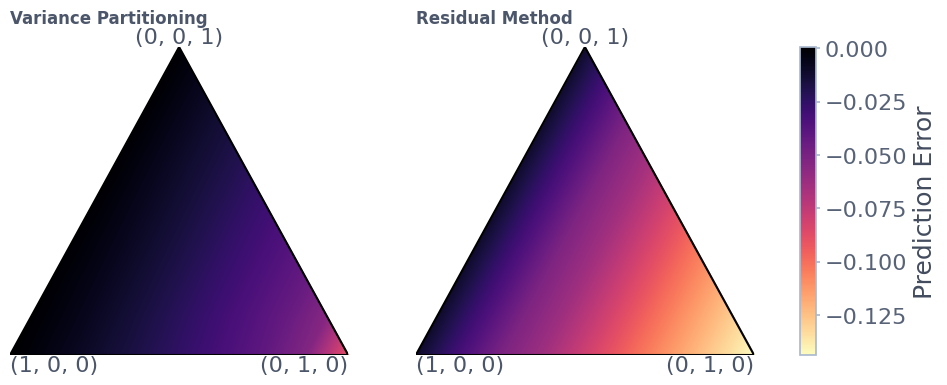

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

min_total = min(min(vp_x1_mean_error_predicted), min(rm_x1_mean_error_predicted))
max_total = max(max(vp_x1_mean_error_predicted), max(rm_x1_mean_error_predicted))

_, _, im_vp_x1 = plot_simplex(vp_x1_mean_error_predicted, ax=axs[0], min_total=min_total, max_total=max_total)
_, _, im_rm_x1 = plot_simplex(rm_x1_mean_error_predicted, ax=axs[1], min_total=min_total, max_total=max_total)

# add colorbar based on max values to figure
cbar = fig.colorbar(im_vp_x1, ax=axs)
cbar.set_label('Prediction Error')

# add column wise titles
axs[0].set_title(r'Variance Partitioning', y=1.05, fontsize=12)
axs[1].set_title(r'Residual Method', y=1.05, fontsize=12)

Text(0, 0.5, 'Residual Method')

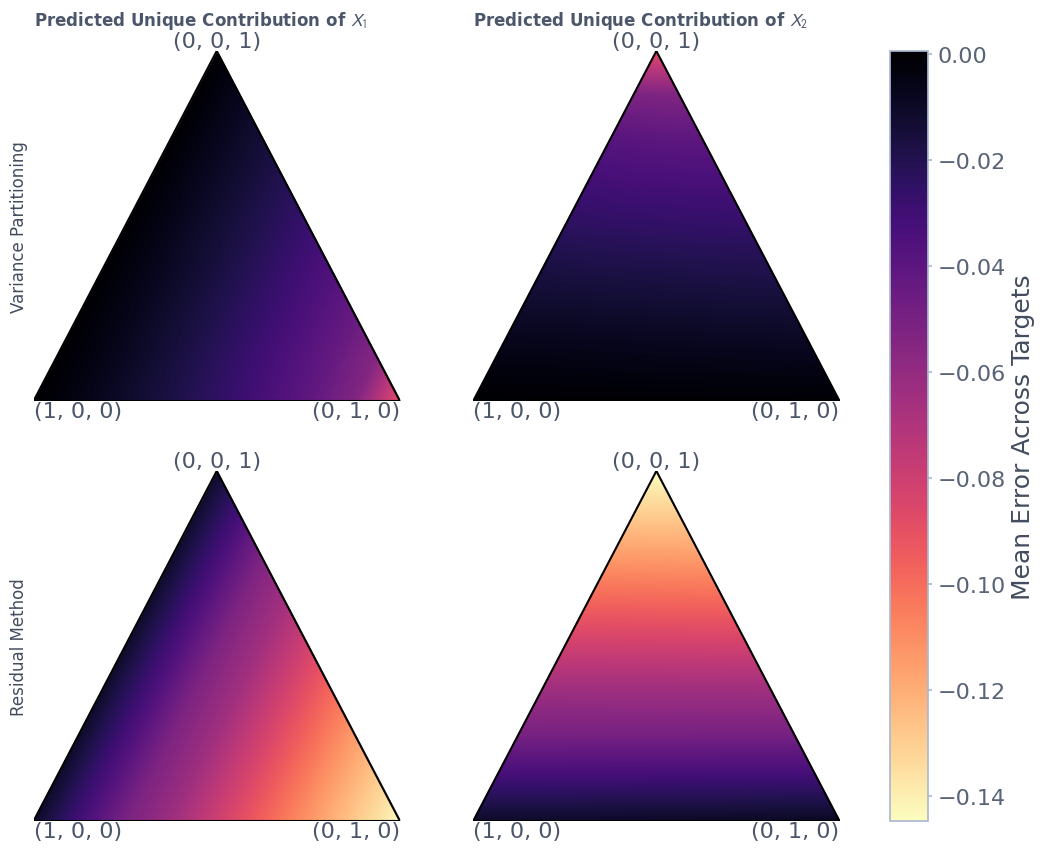

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(13, 10))

min_total = min(min(vp_x1_mean_error_predicted), min(vp_x2_mean_error_predicted), min(rm_x1_mean_error_predicted),
                min(rm_x2_mean_error_predicted))
max_total = max(max(vp_x1_mean_error_predicted), max(vp_x2_mean_error_predicted), max(rm_x1_mean_error_predicted),
                max(rm_x2_mean_error_predicted))

_, _, im_vp_x1 = plot_simplex(vp_x1_mean_error_predicted, ax=axs[0, 0], min_total=min_total, max_total=max_total)
_, _, im_vp_x2 = plot_simplex(vp_x2_mean_error_predicted, ax=axs[0, 1], min_total=min_total, max_total=max_total)
_, _, im_rm_x1 = plot_simplex(rm_x1_mean_error_predicted, ax=axs[1, 0], min_total=min_total, max_total=max_total)
_, _, im_rm_x2 = plot_simplex(rm_x2_mean_error_predicted, ax=axs[1, 1], min_total=min_total, max_total=max_total)

# add colorbar based on max values to figure
cbar = fig.colorbar(im_vp_x1, ax=axs)
cbar.set_label('Mean Error Across Targets')

# add column wise titles
axs[0, 0].set_title(r'Predicted Unique Contribution of $X_1$', y=1.05, fontsize=12)
axs[0, 1].set_title(r'Predicted Unique Contribution of $X_2$', y=1.05, fontsize=12)

# add row titles
axs[0, 0].set_ylabel(r'Variance Partitioning', fontsize=12)
axs[1, 0].set_ylabel(r'Residual Method', fontsize=12)

Text(0, 0.5, 'Residual Method')

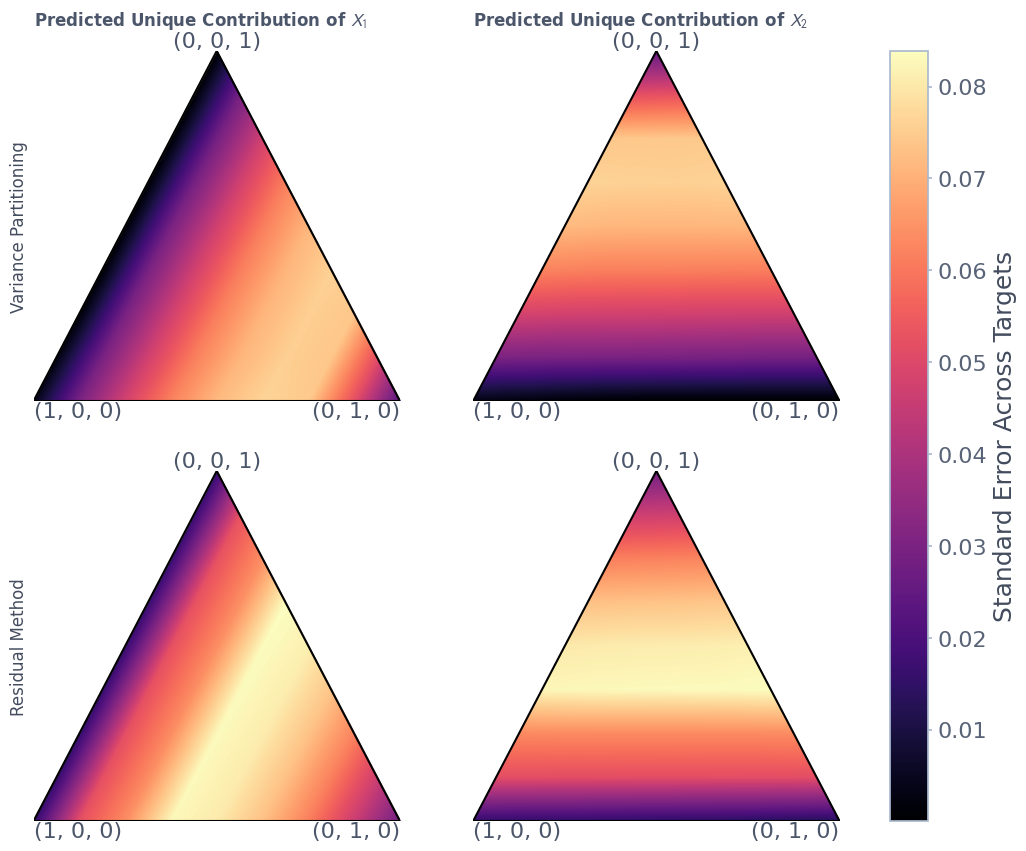

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(13, 10))

min_total = min(min(vp_x1_std_errors), min(vp_x2_std_errors), min(rm_x1_std_errors), min(rm_x2_std_errors))
max_total = max(max(vp_x1_std_errors), max(vp_x2_std_errors), max(rm_x1_std_errors), max(rm_x2_std_errors))

cmap = plt.get_cmap('magma')
_, _, im_vp_x1 = plot_simplex(vp_x1_std_errors, ax=axs[0, 0], min_total=min_total, max_total=max_total, cmap=cmap)
_, _, im_vp_x2 = plot_simplex(vp_x2_std_errors, ax=axs[0, 1], min_total=min_total, max_total=max_total, cmap=cmap)
_, _, im_rm_x1 = plot_simplex(rm_x1_std_errors, ax=axs[1, 0], min_total=min_total, max_total=max_total, cmap=cmap)
_, _, im_rm_x2 = plot_simplex(rm_x2_std_errors, ax=axs[1, 1], min_total=min_total, max_total=max_total, cmap=cmap)

# add colorbar based on max values to figure
cbar = fig.colorbar(im_vp_x1, ax=axs, cmap='magma')
cbar.set_label('Standard Error Across Targets')

# add column wise titles
axs[0, 0].set_title(r'Predicted Unique Contribution of $X_1$', y=1.05, fontsize=12)
axs[0, 1].set_title(r'Predicted Unique Contribution of $X_2$', y=1.05, fontsize=12)

# add row titles
axs[0, 0].set_ylabel(r'Variance Partitioning', fontsize=12)
axs[1, 0].set_ylabel(r'Residual Method', fontsize=12)

# Plot only a a line on the simplex

In [17]:
shared_scalar = 0.5

In [18]:
# find all paths with this shared scalar
experiment_dir = get_path(alphas, cv, n_targets)
all_paths = os.listdir(experiment_dir)
filtered_paths = []
for path in all_paths:
    if path.__contains__(f"[{shared_scalar}"):
        filtered_paths.append(path)
filtered_paths

['scores_[0.5   0.375 0.125].csv',
 'scores_[0.5  0.25 0.25].csv',
 'scores_[0.5 0.  0.5].csv',
 'scores_[0.5 0.5 0. ].csv',
 'scores_[0.5   0.125 0.375].csv']

In [19]:
# extract scalars from paths
interp_points = np.array(
    [np.fromstring(path.replace("scores_[", "").replace("].csv", ""), dtype=float, count=3, sep=' ') for path in
     filtered_paths]
)
interp_points = interp_points[interp_points[:, 1].argsort()]
interp_points

array([[0.5  , 0.   , 0.5  ],
       [0.5  , 0.125, 0.375],
       [0.5  , 0.25 , 0.25 ],
       [0.5  , 0.375, 0.125],
       [0.5  , 0.5  , 0.   ]])

In [20]:
save_scores(interp_points, d_list, n_targets, n_samples, noise_target, cv, alphas)

[0.5 0.  0.5]
skipping, already exists
[0.5   0.125 0.375]
skipping, already exists
[0.5  0.25 0.25]
skipping, already exists
[0.5   0.375 0.125]
skipping, already exists
[0.5 0.5 0. ]
skipping, already exists


In [21]:
# plot error for variance partitioning and residual method
vp_x1_mean_error_predicted = []
vp_x1_mse = []
rm_x1_mean_error_predicted = []
rm_x1_mse = []

for scalars in interp_points:
    scores = pd.read_csv(os.path.join(get_path(alphas, cv, n_targets), f"scores_{scalars}.csv"))
    vp_predicted = scores["vp_x1_unique_score"]
    rm_predicted = scores["rm_x1_unique_score"]
    vp_x1_mean_error_predicted.append(vp_predicted.mean())
    rm_x1_mean_error_predicted.append(rm_predicted.mean())
    vp_x1_mse.append((vp_predicted - scalars[1]).std())
    rm_x1_mse.append((rm_predicted - scalars[1]).std())

vp_x1_mean_error_predicted, vp_x1_mse, rm_x1_mean_error_predicted, rm_x1_mse = map(np.array, (
    vp_x1_mean_error_predicted, vp_x1_mse, rm_x1_mean_error_predicted, rm_x1_mse))

vp = pd.DataFrame(
    {
        'true_scores': interp_points[:, 1],
        'avg': vp_x1_mean_error_predicted,
        'mse': vp_x1_mse,
        'lower_mse': vp_x1_mean_error_predicted - vp_x1_mse,
        'upper_mse': vp_x1_mean_error_predicted + vp_x1_mse
    }
)
rm = pd.DataFrame(
    {
        'true_scores': interp_points[:, 1],
        'avg': rm_x1_mean_error_predicted,
        'mse': rm_x1_mse,
        'lower_mse': rm_x1_mean_error_predicted - rm_x1_mse,
        'upper_mse': rm_x1_mean_error_predicted + rm_x1_mse,
    }
)
vp

,true_scores,avg,mse,lower_mse,upper_mse
0,0.000,-0.000140,0.000942,-0.001082,0.000802
1,0.125,0.118628,0.029652,0.088975,0.148280
2,0.250,0.237559,0.047431,0.190128,0.284990
3,0.375,0.356105,0.061402,0.294703,0.417507
4,0.500,0.475026,0.071835,0.403191,0.546862


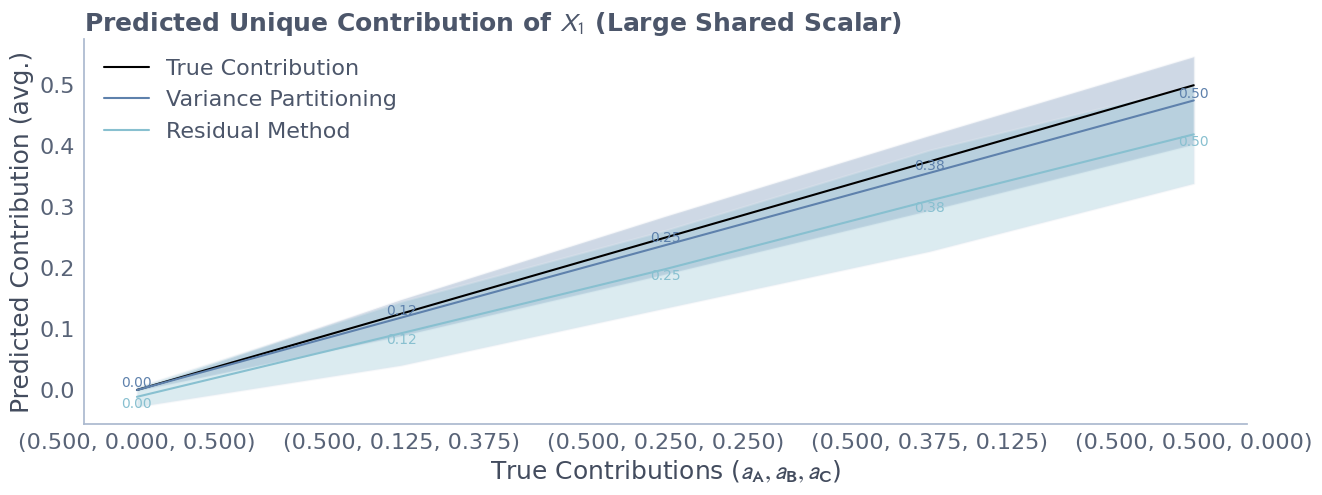

In [22]:
# create line plot following b_scalar
fig, axs = plt.subplots(figsize=(3 * len(interp_points), 5))
x = range(len(interp_points))

# plot line for each point in edges
plt.plot(x, interp_points[:, 1], label=f"True Contribution", color='black')

# add xticks of points
plt.xticks(x, [f"({x[0]:.3f}, {x[1]:.3f}, {x[2]:.3f})" for x in interp_points])

# plot error
plt.plot(x, vp['avg'], label="Variance Partitioning")
plt.plot(x, rm['avg'], label="Residual Method")
plt.fill_between(x, vp['lower_mse'], vp['upper_mse'], alpha=0.3)
plt.fill_between(x, rm['lower_mse'], rm['upper_mse'], alpha=0.3)
# plt.errorbar(x, vp_x1_mean_error_predicted, yerr=vp_x1_mse)
# plt.errorbar(x, rm_x1_mean_error_predicted, yerr=rm_x1_mse)

# Annotate each point for Variance Partitioning
for i in x:
    plt.text(i, vp['avg'][i], f"{vp['true_scores'][i]:.2f}", fontsize=10, ha='center',
             va='bottom', color='C0')
    plt.text(i, rm['avg'][i], f"{rm['true_scores'][i]:.2f}", fontsize=10, ha='center',
             va='top', color='C1')

# add labels
plt.xlabel(r"True Contributions ($a_\mathbf{A}, a_\mathbf{B}, a_\mathbf{C}$)")
plt.ylabel("Predicted Contribution (avg.)")
plt.title(r"Predicted Unique Contribution of $X_1$ (Large Shared Scalar)")

plt.legend()